In [1]:
import os
import numpy as np
import scipy.io as sio



In [ ]:

# Define path to the training set folder
#training_path = r"C:\Users\homak\Desktop\Speech_imagery"
training_path = 'Training set'

# Initialize list to store data and labels
X_all = []
y_all = []

# Loop through 15 subjects
for subject_id in range(1, 2):
    file_name = f'Data_Sample{str(subject_id).zfill(2)}.mat'
    file_path = os.path.join(training_path, file_name)

    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        continue

    raw_data = sio.loadmat(file_path)
    data = raw_data['epo_train']['x'][0][0].T      # shape: (trials, channels, time)
    label = raw_data['epo_train']['y'][0][0].T     # shape: (trials, classes)

    # Convert one-hot to class index (0 to 4)
    label = np.argmax(label, axis=1)

    X_all.append(data)
    y_all.append(label)

# Concatenate all subjects’ data
X_train = np.concatenate(X_all, axis=0)  
y_train = np.concatenate(y_all, axis=0)  

# Print shapes
print("✅ X_train shape:", X_train.shape)   
print("✅ y_train shape:", y_train.shape)   


✅ X_train shape: (300, 64, 795)
✅ y_train shape: (300,)


In [3]:
X_train.shape

(300, 64, 795)

In [4]:
from sklearn.model_selection import train_test_split

# Split data: 80% train, 20% test (you can adjust test_size as needed)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, shuffle=True
)

# Print shapes
print("🔹 X_train_split shape:", X_train_split.shape)
print("🔹 y_train_split shape:", y_train_split.shape)
print("🔹 X_test_split shape:", X_test_split.shape)
print("🔹 y_test_split shape:", y_test_split.shape)


🔹 X_train_split shape: (255, 64, 795)
🔹 y_train_split shape: (255,)
🔹 X_test_split shape: (45, 64, 795)
🔹 y_test_split shape: (45,)


In [5]:
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    """Create bandpass Butterworth filter coefficients."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

#def apply_bandpass_filter(data, lowcut=30.0, highcut=100.0, fs=256.0, order=5):
def apply_bandpass_filter(data, lowcut=30.0, highcut=100.0, fs=256.0, order=5):
    """
    Apply bandpass filter to EEG data of shape (n_trials, n_channels, n_samples).
    """
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered_data = np.zeros_like(data)

    for trial in range(data.shape[0]):
        for channel in range(data.shape[1]):
            filtered_data[trial, channel, :] = filtfilt(b, a, data[trial, channel, :])

    return filtered_data


Apply bandpass filter

In [ ]:

fs = 256.0


X_train = apply_bandpass_filter(X_train_split, lowcut=30.0, highcut=100.0, fs=fs)
X_test = apply_bandpass_filter(X_test_split, lowcut=30.0, highcut=100.0, fs=fs)

# چاپ شکل نهایی
print("✅ Gamma-band X_train shape:", X_train.shape)  # expected: (4500, 64, 795)
print("✅ Gamma-band X_val shape  :", X_test.shape)    # expected: (750, 64, 795)


✅ Gamma-band X_train shape: (255, 64, 795)
✅ Gamma-band X_val shape  : (45, 64, 795)


In [7]:
# Reshape data: add channel dimension
X_train_reshaped = X_train.reshape(-1, 64, 795, 1)
X_test_reshaped = X_test.reshape(-1, 64, 795, 1)

In [8]:
# Assuming eeg_data has shape (1275, 64, 795, 1)
channels_2_9 = X_train_reshaped[:, 2:10, :, :]
channels_11_32 = X_train_reshaped[:, 11:33, :, :]
channels_34_63 = X_train_reshaped[:, 34:64, :, :]

# Concatenate the selected channels
X_train_reshaped = np.concatenate([channels_2_9, channels_11_32, channels_34_63], axis=1)

In [9]:
# Assuming eeg_data has shape (1275, 64, 795, 1)
channels_2_9_test = X_test_reshaped[:, 2:10, :, :]
channels_11_32_test = X_test_reshaped[:, 11:33, :, :]
channels_34_63_test = X_test_reshaped[:, 34:64, :, :]

# Concatenate the selected channels
X_test_reshaped = np.concatenate([channels_2_9_test, channels_11_32_test, channels_34_63_test], axis=1)

In [10]:
X_train_reshaped.shape

(255, 60, 795, 1)

In [11]:
import numpy as np

def augment_with_windowing(data, labels, window_size=256, step_size=1):
    num_trials, num_channels, num_timepoints, num_features = data.shape
    X_augmented = []
    y_augmented = []

    for i in range(num_trials):
        for start in range(0, num_timepoints - window_size + 1, step_size):
            end = start + window_size
            window = data[i, :, start:end, :]  # shape: (60, window_size, 1)
            X_augmented.append(window)
            y_augmented.append(labels[i])  # repeat the same label

    return np.array(X_augmented), np.array(y_augmented)


In [12]:
X_test, y_test = augment_with_windowing(X_test_reshaped, y_test_split, window_size=256, step_size=1)
print("✅ Augmented shape:", X_test.shape)  # (num_new_samples, 60, 256, 1)
print("✅ Labels shape   :", y_test.shape)

✅ Augmented shape: (24300, 60, 256, 1)
✅ Labels shape   : (24300,)


In [13]:
np.savez_compressed("data_test.npz", X_test=X_test, y_test=y_test)

print(f"✅ Saved augmented test set to: data_test")

✅ Saved augmented test set to: data_test


In [14]:
data = np.load("data_test.npz")
X_test_loaded = data["X_test"]
y_test_loaded = data["y_test"]

print("Loaded shapes:", X_test_loaded.shape, y_test_loaded.shape)


Loaded shapes: (24300, 60, 256, 1) (24300,)


In [15]:
X_train, y_train = augment_with_windowing(X_train_reshaped, y_train_split, window_size=256, step_size=1)
print("✅ Augmented shape:", X_train.shape)  # (num_new_samples, 60, 256, 1)
print("✅ Labels shape   :", y_train.shape)


✅ Augmented shape: (137700, 60, 256, 1)
✅ Labels shape   : (137700,)


In [16]:
np.savez_compressed("data_train.npz", X_train=X_train, y_train=y_train)
print("✅ Saved augmented train set to: data_train.npz")


✅ Saved augmented train set to: data_train.npz


In [18]:
train_data = np.load("data_train.npz")
X_train_loaded, y_train_loaded = train_data["X_train"], train_data["y_train"]

In [19]:

print("Train shapes:", X_train_loaded.shape, y_train_loaded.shape)

Train shapes: (137700, 60, 256, 1) (137700,)


In [20]:
from keras.models import Model
from keras import Sequential, layers, regularizers
from keras.layers import Dense, Activation, Dropout, Input, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from keras.regularizers import l1_l2

from keras.optimizers import Adam

In [21]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train.reshape(-1,1)).toarray()
y_test = enc.fit_transform(y_test.reshape(-1,1)).toarray()

In [22]:


CNN1 = Sequential()

CNN1.add(Conv2D(50, (30,1), input_shape=(60, 256, 1), padding='same'))
CNN1.add(BatchNormalization())
CNN1.add(layers.Activation("elu"))
CNN1.add(Conv2D(50, (1,60)))
CNN1.add(BatchNormalization())
CNN1.add(layers.Activation("elu"))

CNN1.add(MaxPooling2D((3,1), strides=(3), padding="same"))
CNN1.add(Flatten())

CNN1.add(Dense(units=1024,kernel_initializer="uniform", kernel_regularizer= regularizers.l2(0.01), activation='elu'))
CNN1.add(Dense(units=5, kernel_initializer="uniform", activation="softmax"))
adam = Adam(learning_rate=0.0001)
CNN1.compile(adam, loss="categorical_crossentropy", metrics=["accuracy"])


c:\Users\nit\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = CNN1.fit(X_train, y_train, batch_size=128, epochs=300, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/300
861/861 ━━━━━━━━━━━━━━━━━━━━ 6683s 8s/step - accuracy: 0.2685 - loss: 361.7338 - val_accuracy: 0.2861 - val_loss: 37.7425
Epoch 2/300
861/861 ━━━━━━━━━━━━━━━━━━━━ 6689s 8s/step - accuracy: 0.3967 - loss: 21.4855 - val_accuracy: 0.3989 - val_loss: 3.4121
Epoch 3/300
861/861 ━━━━━━━━━━━━━━━━━━━━ 6678s 8s/step - accuracy: 0.5355 - loss: 2.2365 - val_accuracy: 0.4332 - val_loss: 1.7948
Epoch 4/300
861/861 ━━━━━━━━━━━━━━━━━━━━ 6687s 8s/step - accuracy: 0.6755 - loss: 1.1626 - val_accuracy: 0.4334 - val_loss: 1.7184
Epoch 5/300
861/861 ━━━━━━━━━━━━━━━━━━━━ 6667s 8s/step - accuracy: 0.8294 - loss: 0.8401 - val_accuracy: 0.4235 - val_loss: 2.0996
Epoch 6/300
861/861 ━━━━━━━━━━━━━━━━━━━━ 6613s 8s/step - accuracy: 0.9411 - loss: 0.5971 - val_accuracy: 0.4108 - val_loss: 1.9135
Epoch 7/300
861/861 ━━━━━━━━━━━━━━━━━━━━ 6792s 8s/step - accuracy: 0.9758 - loss: 0.4578 - val_accuracy: 0.4036 - val_loss: 2.2845


<function matplotlib.pyplot.show(close=None, block=None)>

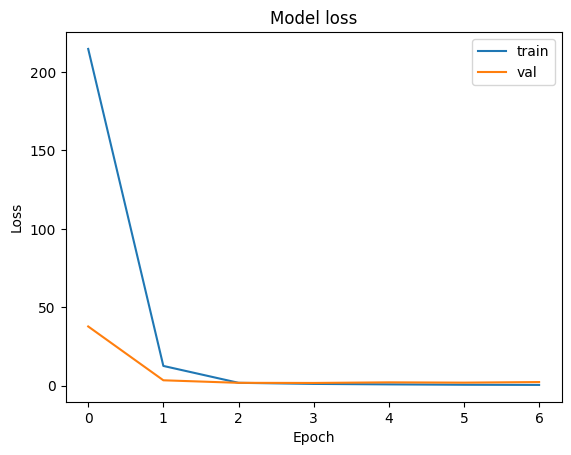

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc="upper right")
plt.show

In [ ]:
extract = Model(CNN1.inputs, CNN1.layers[7].output)
features = extract.predict(X_test)

In [ ]:
features.shape

(24300, 66000)

In [ ]:
np.savez_compressed('extracted_features_test.npz', features=features)
print("Features saved to 'extracted_features_test.npz'")


Features saved to 'extracted_features_test.npz'


In [ ]:
data = np.load('extracted_features_test.npz')
features = data['features']
print("Features loaded, shape:", features.shape)

In [ ]:
import keras
Fusion = Sequential()
Fusion.add(Dense(units = 100, kernel_initializer = 'uniform',kernel_regularizer=regularizers.l2(0.03), activation = 'elu')) # L2 regularization

Fusion.add(Dense(units = 100, kernel_initializer = 'uniform',kernel_regularizer=regularizers.l2(0.03), activation = 'elu')) # L2 regularization
Fusion.add(Dropout(rate=0.1))
# Last Layer
Fusion.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'softmax'))
Fusion.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
features1, features2, y_test1, y_test2 = train_test_split(
    features,
    y_test,
    test_size=0.2,        # ۲۰٪ برای ارزیابی نهایی
    random_state=42,
    stratify=y_test       # حفظ تناسب کلاس‌ها
)

In [ ]:
print(features1.shape)
print(features2.shape)
print(y_test1.shape)
print(y_test2.shape)

(19440, 66000)
(4860, 66000)
(19440, 5)
(4860, 5)


In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience = 7)
history= Fusion.fit(features1, y_test1, batch_size = 128, epochs = 500, validation_split = 0.15, callbacks=[early_stopping])

Epoch 1/500
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.3600 - loss: 139.7347 - val_accuracy: 0.4767 - val_loss: 76.4092
Epoch 2/500
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.5359 - loss: 63.3953 - val_accuracy: 0.6001 - val_loss: 33.8507
Epoch 3/500
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6675 - loss: 27.9582 - val_accuracy: 0.6742 - val_loss: 14.9935
Epoch 4/500
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.7988 - loss: 12.3806 - val_accuracy: 0.7404 - val_loss: 6.9819
Epoch 5/500
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.8716 - loss: 5.7608 - val_accuracy: 0.6814 - val_loss: 3.8190
Epoch 6/500
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9116 - loss: 3.0171 - val_accuracy: 0.9156 - val_loss: 2.0739
Epoch 7/500
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9614 - loss: 1.7662 - val_accuracy: 0.8481 - val_loss: 1.4576
Epoch 8/500
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9797 - loss: 

In [ ]:
loss,test_accuracy = Fusion.evaluate(features2, y_test2,  verbose=1)

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9974 - loss: 0.2736


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


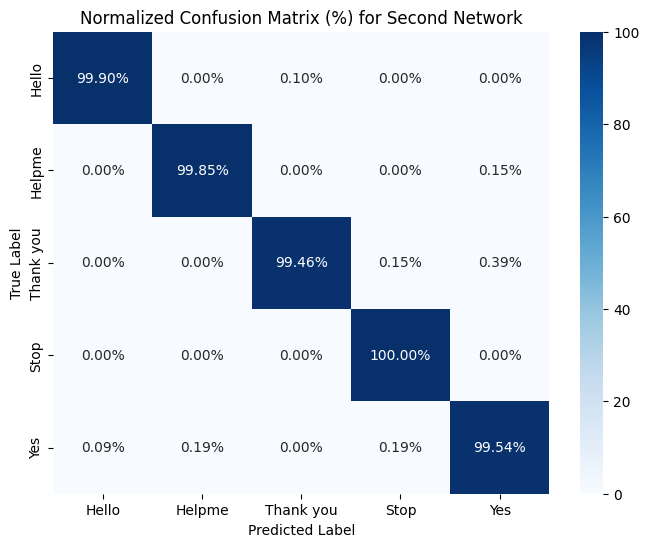

              precision    recall  f1-score   support

       Hello       1.00      1.00      1.00       972
      Helpme       1.00      1.00      1.00       648
   Thank you       1.00      0.99      1.00      1296
        Stop       1.00      1.00      1.00       864
         Yes       0.99      1.00      0.99      1080

    accuracy                           1.00      4860
   macro avg       1.00      1.00      1.00      4860
weighted avg       1.00      1.00      1.00      4860



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


class_names = ['Hello', 'Helpme', 'Thank you', 'Stop', 'Yes']


y_prob = Fusion.predict(features2)                  
y_pred = np.argmax(y_prob, axis=1)                 
y_true = np.argmax(y_test2, axis=1)                 

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
labels = np.array([f"{v:.2f}%" for v in cm_norm.flatten()]).reshape(cm_norm.shape)

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=labels, fmt='', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (%) for Second Network')
plt.show()


print(classification_report(y_true, y_pred, target_names=class_names))


Training set: 19440 samples, 66000 features
Test set:     4860 samples, 66000 features

Test Accuracy: 0.7315

Classification Report:
              precision    recall  f1-score   support

       Hello       0.89      0.72      0.80       972
      Helpme       0.56      0.75      0.65       648
   Thank you       0.79      0.67      0.73      1296
        Stop       0.74      0.73      0.74       864
         Yes       0.68      0.81      0.74      1080

    accuracy                           0.73      4860
   macro avg       0.74      0.74      0.73      4860
weighted avg       0.75      0.73      0.73      4860



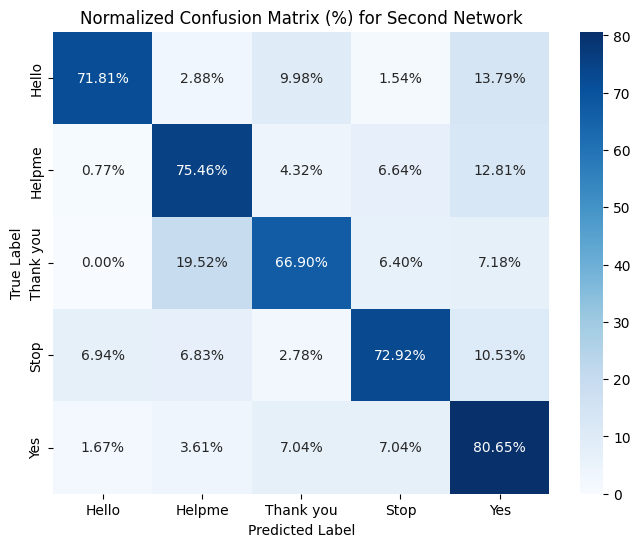

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# نام کلاس‌ها (همان ترتیب ایندکس‌ها)
class_names = ['Hello', 'Helpme', 'Thank you', 'Stop', 'Yes']

# 1) تبدیل one-hot به ایندکس
y_trainn = np.argmax(y_test1, axis=1)
y_testt  = np.argmax(y_test2, axis=1)

print(f"Training set: {features1.shape[0]} samples, {features1.shape[1]} features")
print(f"Test set:     {features2.shape[0]} samples, {features2.shape[1]} features")

# 2) تعریف و آموزش مدل KNN
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)  # n_jobs=-1 برای استفاده از همه‌ی هسته‌ها
knn.fit(features1, y_trainn)

# 3) پیش‌بینی روی داده‌های تست
y_pred = knn.predict(features2)

# 4) ارزیابی مدل
acc = accuracy_score(y_testt, y_pred)
print(f"\nTest Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_testt, y_pred, target_names=class_names))

# اختیاری: ماتریس کانفیوژن
cm = confusion_matrix(y_testt, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
labels = np.array([f"{v:.2f}%" for v in cm_norm.flatten()]).reshape(cm_norm.shape)

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=labels, fmt='', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (%) for Second Network')
plt.show()




Training set: 19440 samples, 66000 features
Test set:     4860 samples, 66000 features

Test Accuracy (DT): 0.4749

Classification Report (DT):
              precision    recall  f1-score   support

       Hello       0.40      0.40      0.40       972
      Helpme       0.41      0.40      0.41       648
   Thank you       0.57      0.57      0.57      1296
        Stop       0.41      0.42      0.41       864
         Yes       0.52      0.53      0.52      1080

    accuracy                           0.47      4860
   macro avg       0.46      0.46      0.46      4860
weighted avg       0.47      0.47      0.47      4860

Confusion Matrix (counts):
[[388  92 172 155 165]
 [ 90 258  92  96 112]
 [152  91 736 160 157]
 [175  79 159 359  92]
 [168 105 141  99 567]]


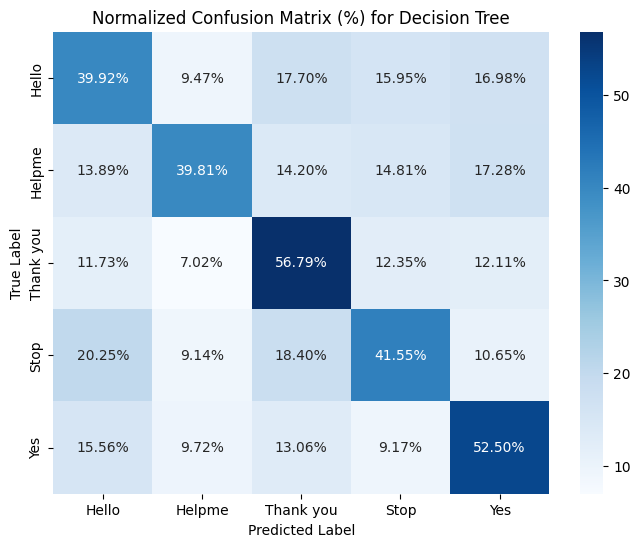

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


class_names = ['Hello', 'Helpme', 'Thank you', 'Stop', 'Yes']


y_train = np.argmax(y_test1, axis=1)
y_test  = np.argmax(y_test2, axis=1)

print(f"Training set: {features1.shape[0]} samples, {features1.shape[1]} features")
print(f"Test set:     {features2.shape[0]} samples, {features2.shape[1]} features")


dt = DecisionTreeClassifier(criterion='gini',    
                            max_depth=None,     
                            min_samples_leaf=1,   
                            random_state=42)


dt.fit(features1, y_train)


y_pred = dt.predict(features2)


acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy (DT): {acc:.4f}\n")

print("Classification Report (DT):")
print(classification_report(y_test, y_pred, target_names=class_names))


cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (counts):")
print(cm)




cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


labels = np.array([f"{v:.2f}%" for v in cm_norm.flatten()]).reshape(cm_norm.shape)


plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=labels, fmt='', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (%) for Decision Tree')
plt.show()


Training set: 19440 samples, 66000 features
Test set:     4860 samples, 66000 features
Iteration 1, loss = 2.91629744
Iteration 2, loss = 0.74899274
Iteration 3, loss = 0.47159636
Iteration 4, loss = 0.20015432
Iteration 5, loss = 0.11201140
Iteration 6, loss = 0.05972326
Iteration 7, loss = 0.03857001
Iteration 8, loss = 0.02410771
Iteration 9, loss = 0.01731417
Iteration 10, loss = 0.01277040
Iteration 11, loss = 0.01001717
Iteration 12, loss = 0.00772753
Iteration 13, loss = 0.00629011
Iteration 14, loss = 0.00522594
Iteration 15, loss = 0.00436337
Iteration 16, loss = 0.00371485
Iteration 17, loss = 0.00320900
Iteration 18, loss = 0.00278936
Iteration 19, loss = 0.00245868
Iteration 20, loss = 0.00218337
Iteration 21, loss = 0.00195403
Iteration 22, loss = 0.00174471
Iteration 23, loss = 0.00157658
Iteration 24, loss = 0.00142821
Iteration 25, loss = 0.00130473
Iteration 26, loss = 0.00119443
Iteration 27, loss = 0.00109155
Iteration 28, loss = 0.00100327
Iteration 29, loss = 0.000

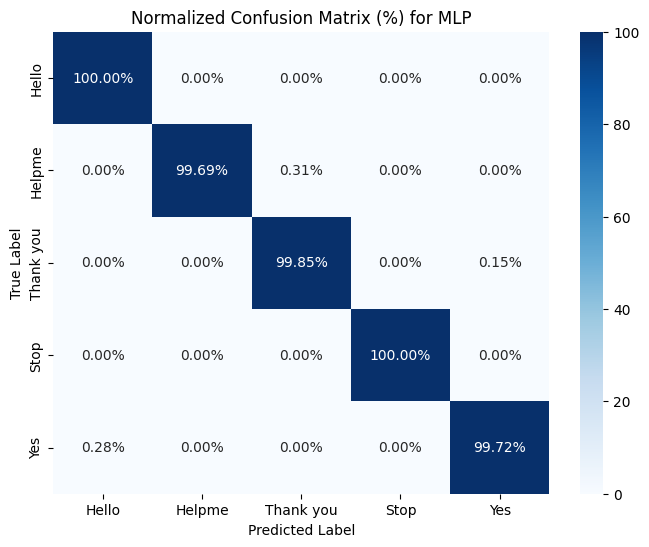

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


class_names = ['Hello', 'Helpme', 'Thank you', 'Stop', 'Yes']


y_train = np.argmax(y_test1, axis=1)
y_test  = np.argmax(y_test2, axis=1)

print(f"Training set: {features1.shape[0]} samples, {features1.shape[1]} features")
print(f"Test set:     {features2.shape[0]} samples, {features2.shape[1]} features")

mlp = MLPClassifier(
    hidden_layer_sizes=(100,100), 
    activation='relu',            
    solver='adam',                 
    alpha=0.0001,                  
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=200,                  
    random_state=42,
    verbose=True
)


mlp.fit(features1, y_train)


y_pred = mlp.predict(features2)


acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy (MLP): {acc:.4f}\n")


print("Classification Report (MLP):")
print(classification_report(y_test, y_pred, target_names=class_names))


cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (counts):")
print(cm)


cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


labels = np.array([f"{v:.2f}%" for v in cm_norm.flatten()]).reshape(cm_norm.shape)


plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=labels, fmt='', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (%) for MLP')
plt.show()


Training set: 19440 samples, 66000 features
Test set:     4860 samples, 66000 features

Test Accuracy (RF): 0.6712

Classification Report (RF):
              precision    recall  f1-score   support

       Hello       0.51      0.76      0.61       972
      Helpme       0.98      0.33      0.49       648
   Thank you       0.66      0.85      0.74      1296
        Stop       0.68      0.46      0.55       864
         Yes       0.86      0.75      0.80      1080

    accuracy                           0.67      4860
   macro avg       0.74      0.63      0.64      4860
weighted avg       0.72      0.67      0.66      4860

Confusion Matrix (counts):
[[ 742    0  206   21    3]
 [ 153  211   85  114   85]
 [ 120    0 1099   47   30]
 [ 326    5  121  400   12]
 [ 121    0  146    3  810]]


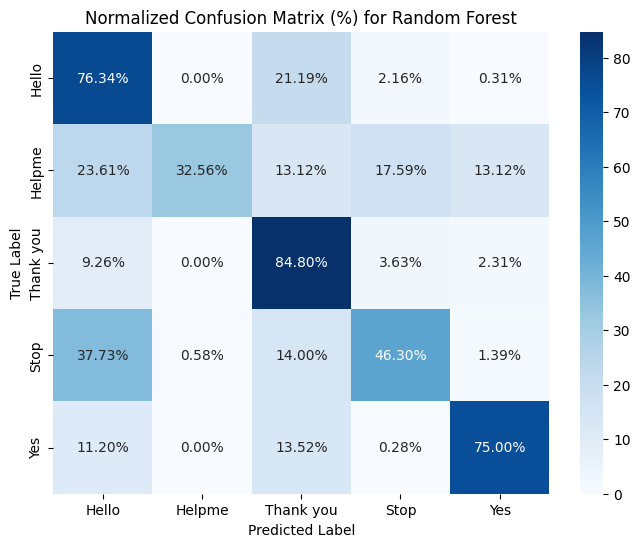

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


class_names = ['Hello', 'Helpme', 'Thank you', 'Stop', 'Yes']


y_trainn = np.argmax(y_test1, axis=1)
y_testt  = np.argmax(y_test2, axis=1)

print(f"Training set: {features1.shape[0]} samples, {features1.shape[1]} features")
print(f"Test set:     {features2.shape[0]} samples, {features2.shape[1]} features")


rf = RandomForestClassifier(
    n_estimators=100,      
    criterion='gini',       
    max_depth=None,        
    min_samples_leaf=1,    
    n_jobs=-1,             
    random_state=42
)
rf.fit(features1, y_trainn)

y_pred = rf.predict(features2)


acc = accuracy_score(y_testt, y_pred)
print(f"\nTest Accuracy (RF): {acc:.4f}\n")

print("Classification Report (RF):")
print(classification_report(y_testt, y_pred, target_names=class_names))


cm = confusion_matrix(y_testt, y_pred)
print("Confusion Matrix (counts):")
print(cm)


cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


labels = np.array([f"{v:.2f}%" for v in cm_norm.flatten()]).reshape(cm_norm.shape)

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=labels, fmt='', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (%) for Random Forest')
plt.show()


Training set: 19440 samples, 66000 features
Test set:     4860 samples, 66000 features


c:\Users\nit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Test Accuracy (AdaBoost): 0.3899

Classification Report (AdaBoost):
              precision    recall  f1-score   support

       Hello       0.35      0.56      0.44       972
      Helpme       0.26      0.16      0.20       648
   Thank you       0.49      0.53      0.51      1296
        Stop       0.40      0.29      0.34       864
         Yes       0.35      0.29      0.31      1080

    accuracy                           0.39      4860
   macro avg       0.37      0.37      0.36      4860
weighted avg       0.38      0.39      0.38      4860

Confusion Matrix (counts):
[[549   2 167 122 132]
 [161 103 144 102 138]
 [202  41 682 113 258]
 [351  62 138 249  64]
 [287 189 257  35 312]]


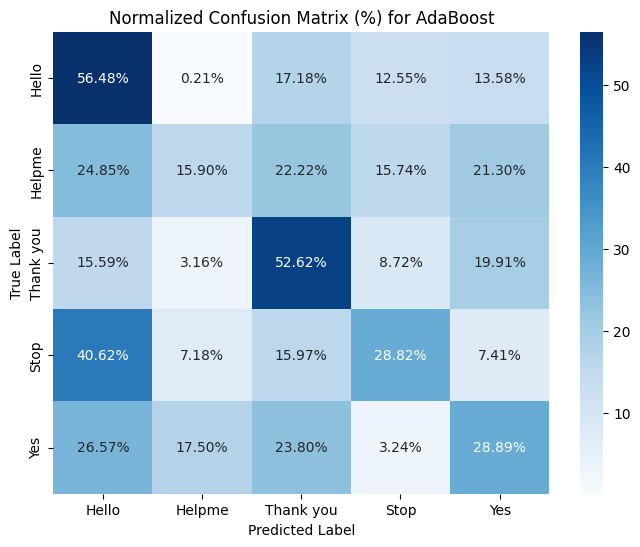

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

class_names = ['Hello', 'Helpme', 'Thank you', 'Stop', 'Yes']


y_trainn = np.argmax(y_test1, axis=1)
y_testt  = np.argmax(y_test2, axis=1)

print(f"Training set: {features1.shape[0]} samples, {features1.shape[1]} features")
print(f"Test set:     {features2.shape[0]} samples, {features2.shape[1]} features")


adb = AdaBoostClassifier(
    n_estimators=50,        
    learning_rate=1.0,      
    algorithm='SAMME',      
    random_state=42
)
adb.fit(features1, y_trainn)

y_pred = adb.predict(features2)


acc = accuracy_score(y_testt, y_pred)
print(f"\nTest Accuracy (AdaBoost): {acc:.4f}\n")

print("Classification Report (AdaBoost):")
print(classification_report(y_testt, y_pred, target_names=class_names))

cm = confusion_matrix(y_testt, y_pred)
print("Confusion Matrix (counts):")
print(cm)


cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
labels = np.array([f"{v:.2f}%" for v in cm_norm.flatten()]).reshape(cm_norm.shape)

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=labels, fmt='', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (%) for AdaBoost')
plt.show()
